In [1]:
import os, pickle
import warnings
#
import matplotlib.pyplot as plt
import numpy as np

#
# tf.logging.set_verbosity(tf.logging.ERROR)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [24]:

def load_output_preprocessed_data(path, win, tr_tst, stock, multi=False):
    '''
    Returns the preprocessed data as a list of objects
    
    Arguments:
    path - path to the preprocessed data
    win - window size
    multi - boolean value to indicate if the data is multivariate or not
    '''
    all_results = {}

    # Directory containing the results files
    directory = f'D:/Escritorio/TFG/Finance-AI/DataProcessed/output/{win}/{tr_tst}/'

    # Get list of files in directory
    files = os.listdir(directory) 

    for file in files: # Loop through each file in the directory
        # Verify if the file is type 'output.pkl' o 'output-m.pkl'
        if file.endswith('-output.pkl') and not multi:
            mdl = file.split('-')[1]
        elif file.endswith('-m-output.pkl') and multi:
            mdl = file.split('-')[1]
        else:
            continue
        
        # Construir la ruta completa del archivo
        fdat = os.path.join(directory, file)

        with (open(fdat, "rb")) as openfile:
            results = {}
            while True:
                try:
                    path      = pickle.load(openfile)
                    fdat      = pickle.load(openfile)
                    lahead    = pickle.load(openfile)
                    lpar      = pickle.load(openfile)
                    tot_res   = pickle.load(openfile)
                    results['path'] = path
                    results['fdat'] = fdat
                    results['lahead'] = lahead
                    results['lpar'] = lpar
                    results['tot_res'] = tot_res
                except EOFError:
                    break
            all_results[mdl] = results

    return all_results

In [25]:
tr_tst = 0.8
processed_path = f"D:/Escritorio/TFG/Finance-AI/DataProcessed/"
win_size = 5
stock = 'AAPL'
multi = False
all_res = load_output_preprocessed_data(processed_path, win_size, tr_tst, stock, multi)

In [26]:
model_list = list(all_res.keys())
model_list

['lstm', 'transformer']

In [27]:
def plot_res(ax, DY, msep, msey, stck, mdl, itr, ahead, tr_tst, num_heads=None, num_layers=None):
    ax.plot(DY.index, DY.Y_real, label="Real Values")
    ax.plot(DY.index, DY.Y_predicted, label=f"{mdl.upper()} predicted", color='orange')
    ax.plot(DY.index, DY.Y_yesterday, label="Historical", color='green')
    ax.set_title(f'{stck} - {mdl.upper()}, Predict {ahead} days ahead. Iter: {itr},\n Heads: {num_heads}, Hidden Layers: {num_layers},\n Train: {tr_tst*100}%')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)
    
    # Agregar texto
    ax.text(.01, .01, 'MSE Predicted=' + str(round(msep,3)), transform=ax.transAxes, ha='left', va='bottom', fontsize=16, color='#FFA500')
    ax.text(.01, .05, 'MSE Historical=' + str(round(msey,3)), transform=ax.transAxes, fontsize=16, ha='left', va='bottom', color='green')


In [51]:
def plot_results_comparison(model_results, lahead, model_list, scen_name, stck, itr, tr_tst, save_path=None, wdth=10, hght=30):
    num_models = len(model_list)
    fig, axs = plt.subplots(len(lahead), len(model_list), figsize=[wdth*num_models, hght])
    
    for j, ahead_val in enumerate(lahead):
        for i, model in enumerate(model_list):
            col = i
            res = model_results[model]['tot_res']['OUT_MODEL'][scen_name][stck][ahead_val]
            DYs = res['DY']
            DY = DYs.loc[itr]
            msep = res['MSEP'][itr]
            msey = res['MSEY'][itr]
            
            if model != 'transformer':
                plot_res(axs[j, col], DY, msep, msey, stck, model, itr, ahead_val, tr_tst)
            else:
                num_heads = res['transformer_parameters'][0]['num_heads']
                num_layers = res['transformer_parameters'][0]['num_layers']
                plot_res(axs[j, col], DY, msep, msey, stck, model, itr, ahead_val, tr_tst, num_heads, num_layers)
                
            # Ajustar los límites del eje X y Y
            axs[j, col].set_xlim(DY.index.min(), DY.index.max())  # Ajustar los límites del eje X
            axs[j, col].set_ylim(120, 200)
    
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.tight_layout()
        figfich = os.path.join(save_path, f'{stck}-{itr}-{num_heads}-{num_layers}.png')
        plt.savefig(figfich)
    else:
        plt.tight_layout()
        plt.show()


In [57]:
def plot_perf(model_results, lahead, model_list, stock_list, list_tr_tst, wdth=10, hght=15):
    num_models = len(model_list)
    fig, axes = plt.subplots(len(list_tr_tst), num_models, figsize=[wdth*num_models, hght])

    for stock in stock_list:
        for i, tr_tst in enumerate(list_tr_tst):
            for j, model in enumerate(model_list):
                res = model_results[model]['tot_res']['OUT_MODEL']['scenario_1'][stock]
                lstd = {}
                yval = {}
                for ahead in lahead:
                    lstd[ahead] = res[ahead]['MSEP']
                    yval[ahead] = res[ahead]['MSEY'][0]

                h = list(range(len(lstd)))
                bp = np.array(list(lstd.values()))

                ax = axes[i, j]  # Acceder al eje en la posición i, j
                ax.boxplot(bp.T, positions=h, showmeans=True, manage_ticks=False)
                ax.plot(h, yval.values(), '--ko', c='red', label='Yesterday')
                ax.set_xticks(h)
                ax.set_xticklabels(list(lstd.keys()), rotation='vertical')
                ax.set_xlabel('Stocks')
                ax.set_ylabel('MSE of the 10 simulations')
                ax.set_yscale('log')
                ax.set_title(f'{model.upper()} for {stock} and {tr_tst*100}% train')
                ax.legend()

        plt.tight_layout()
        plt.show()


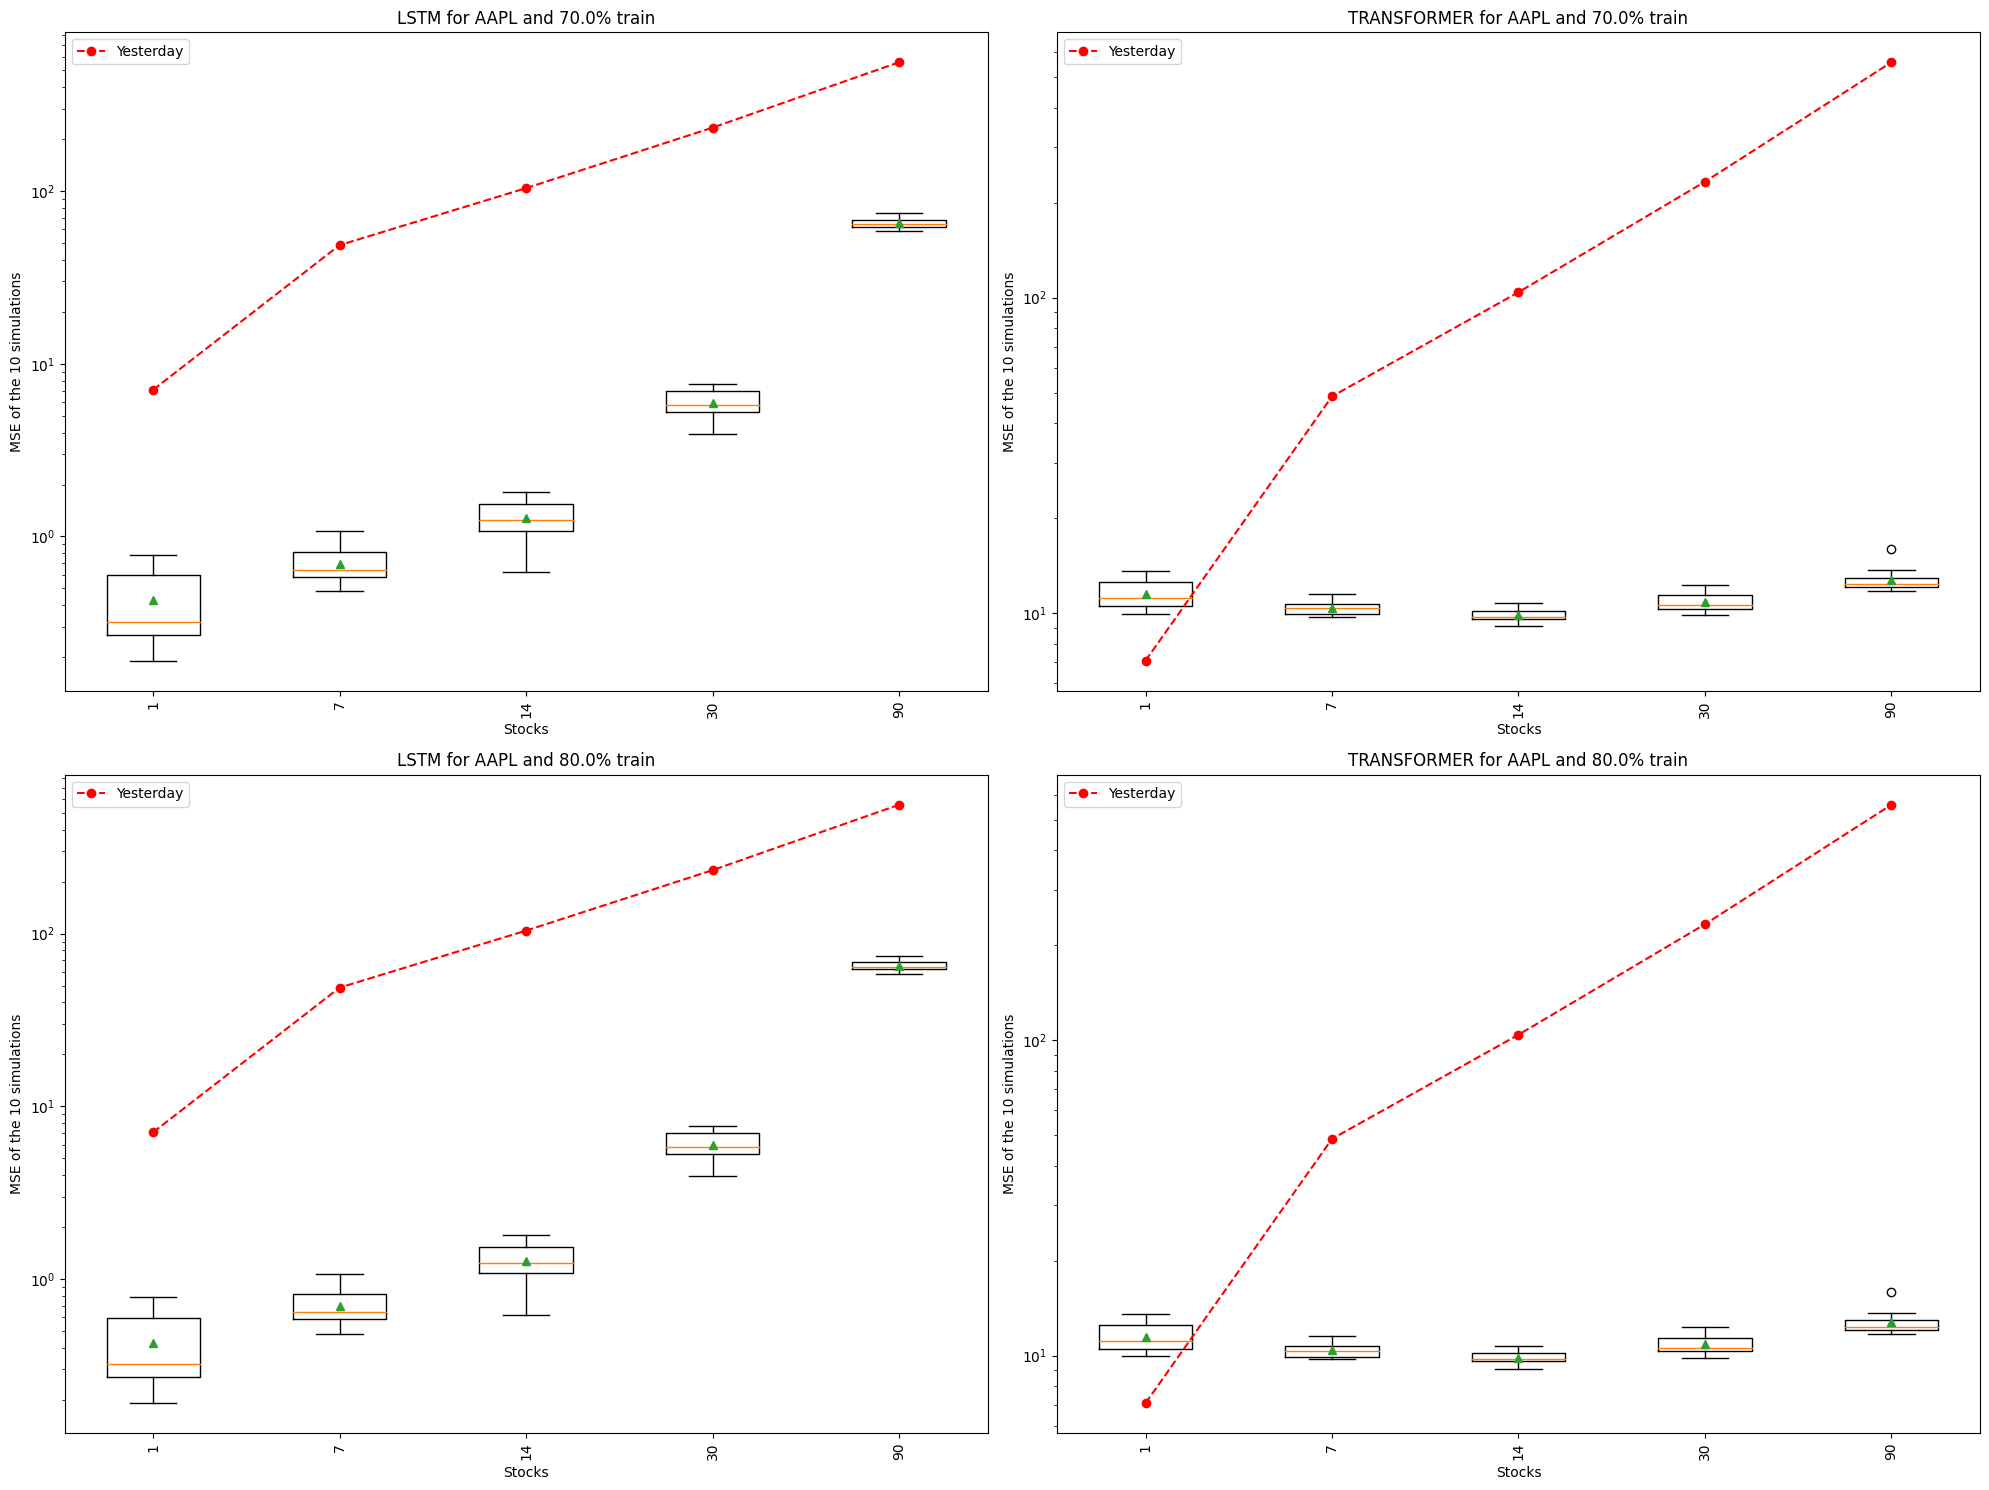

In [59]:
stock_list = ['AAPL']
lahead = [1,7,14,30,90]
list_tr_tst = [0.7,0.8]
plot_perf(all_res, lahead, model_list, stock_list, list_tr_tst)


Plotting model with 70.0% of training data.


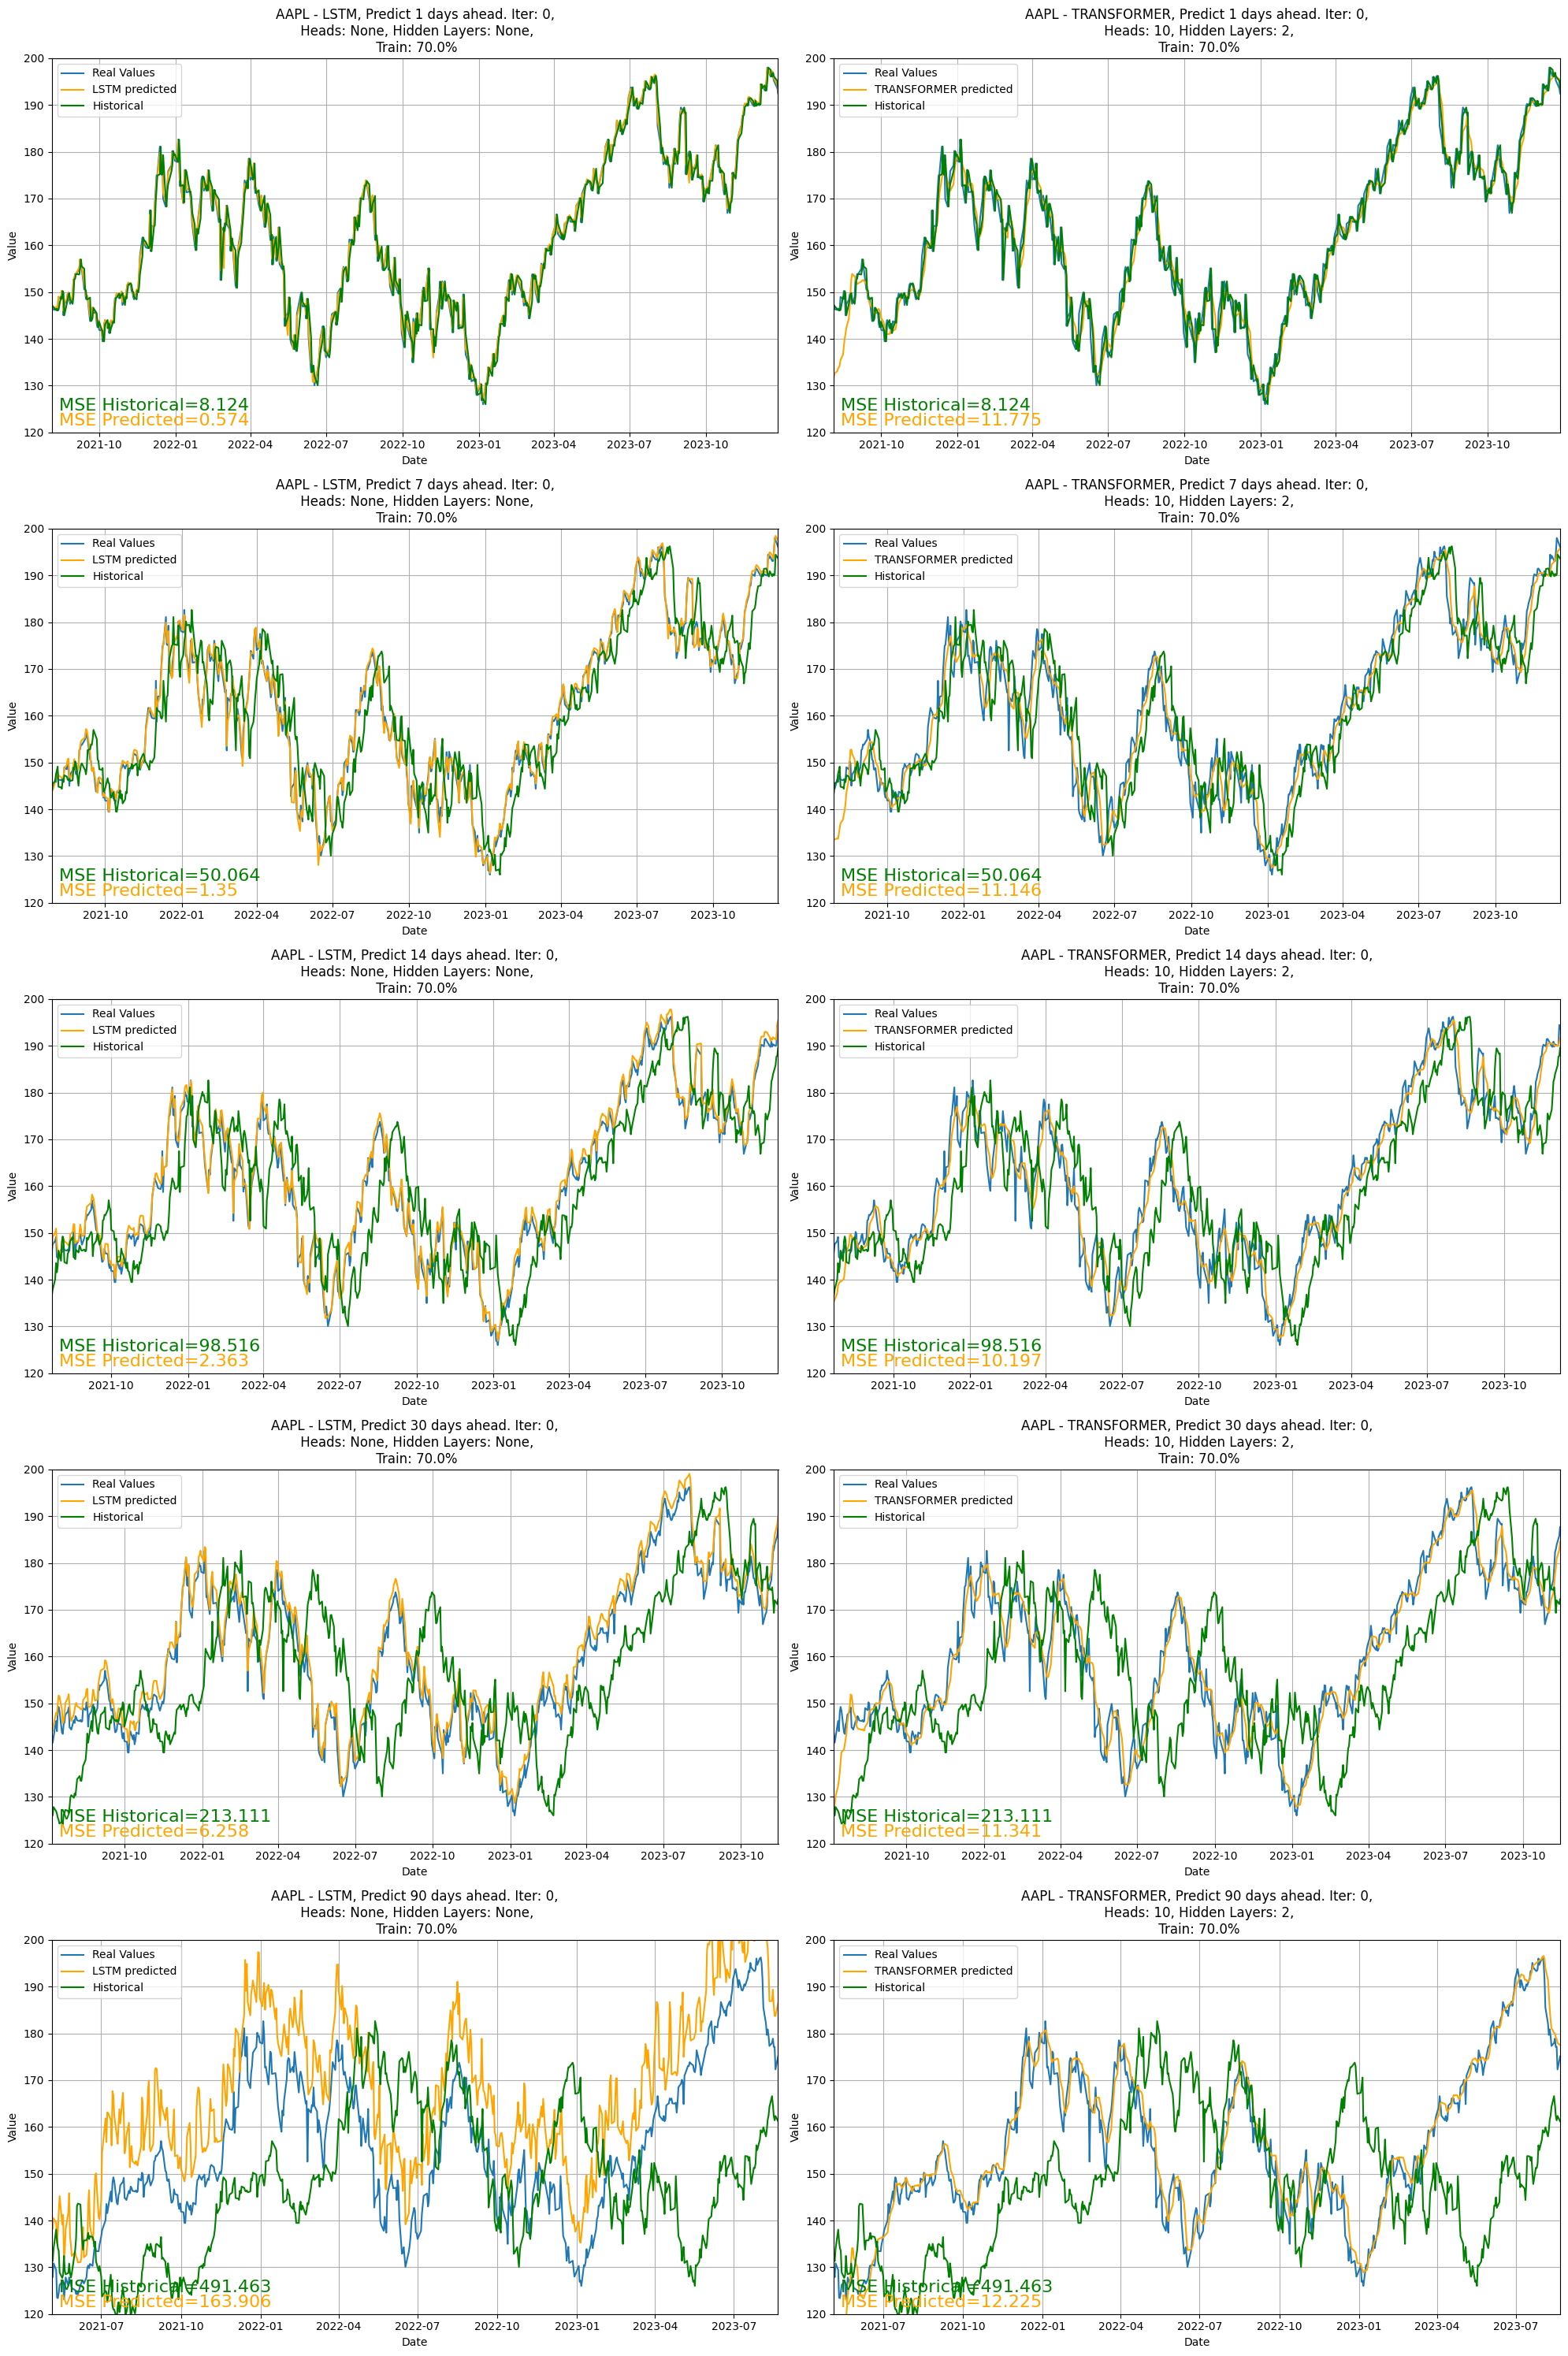

Plotting model with 80.0% of training data.


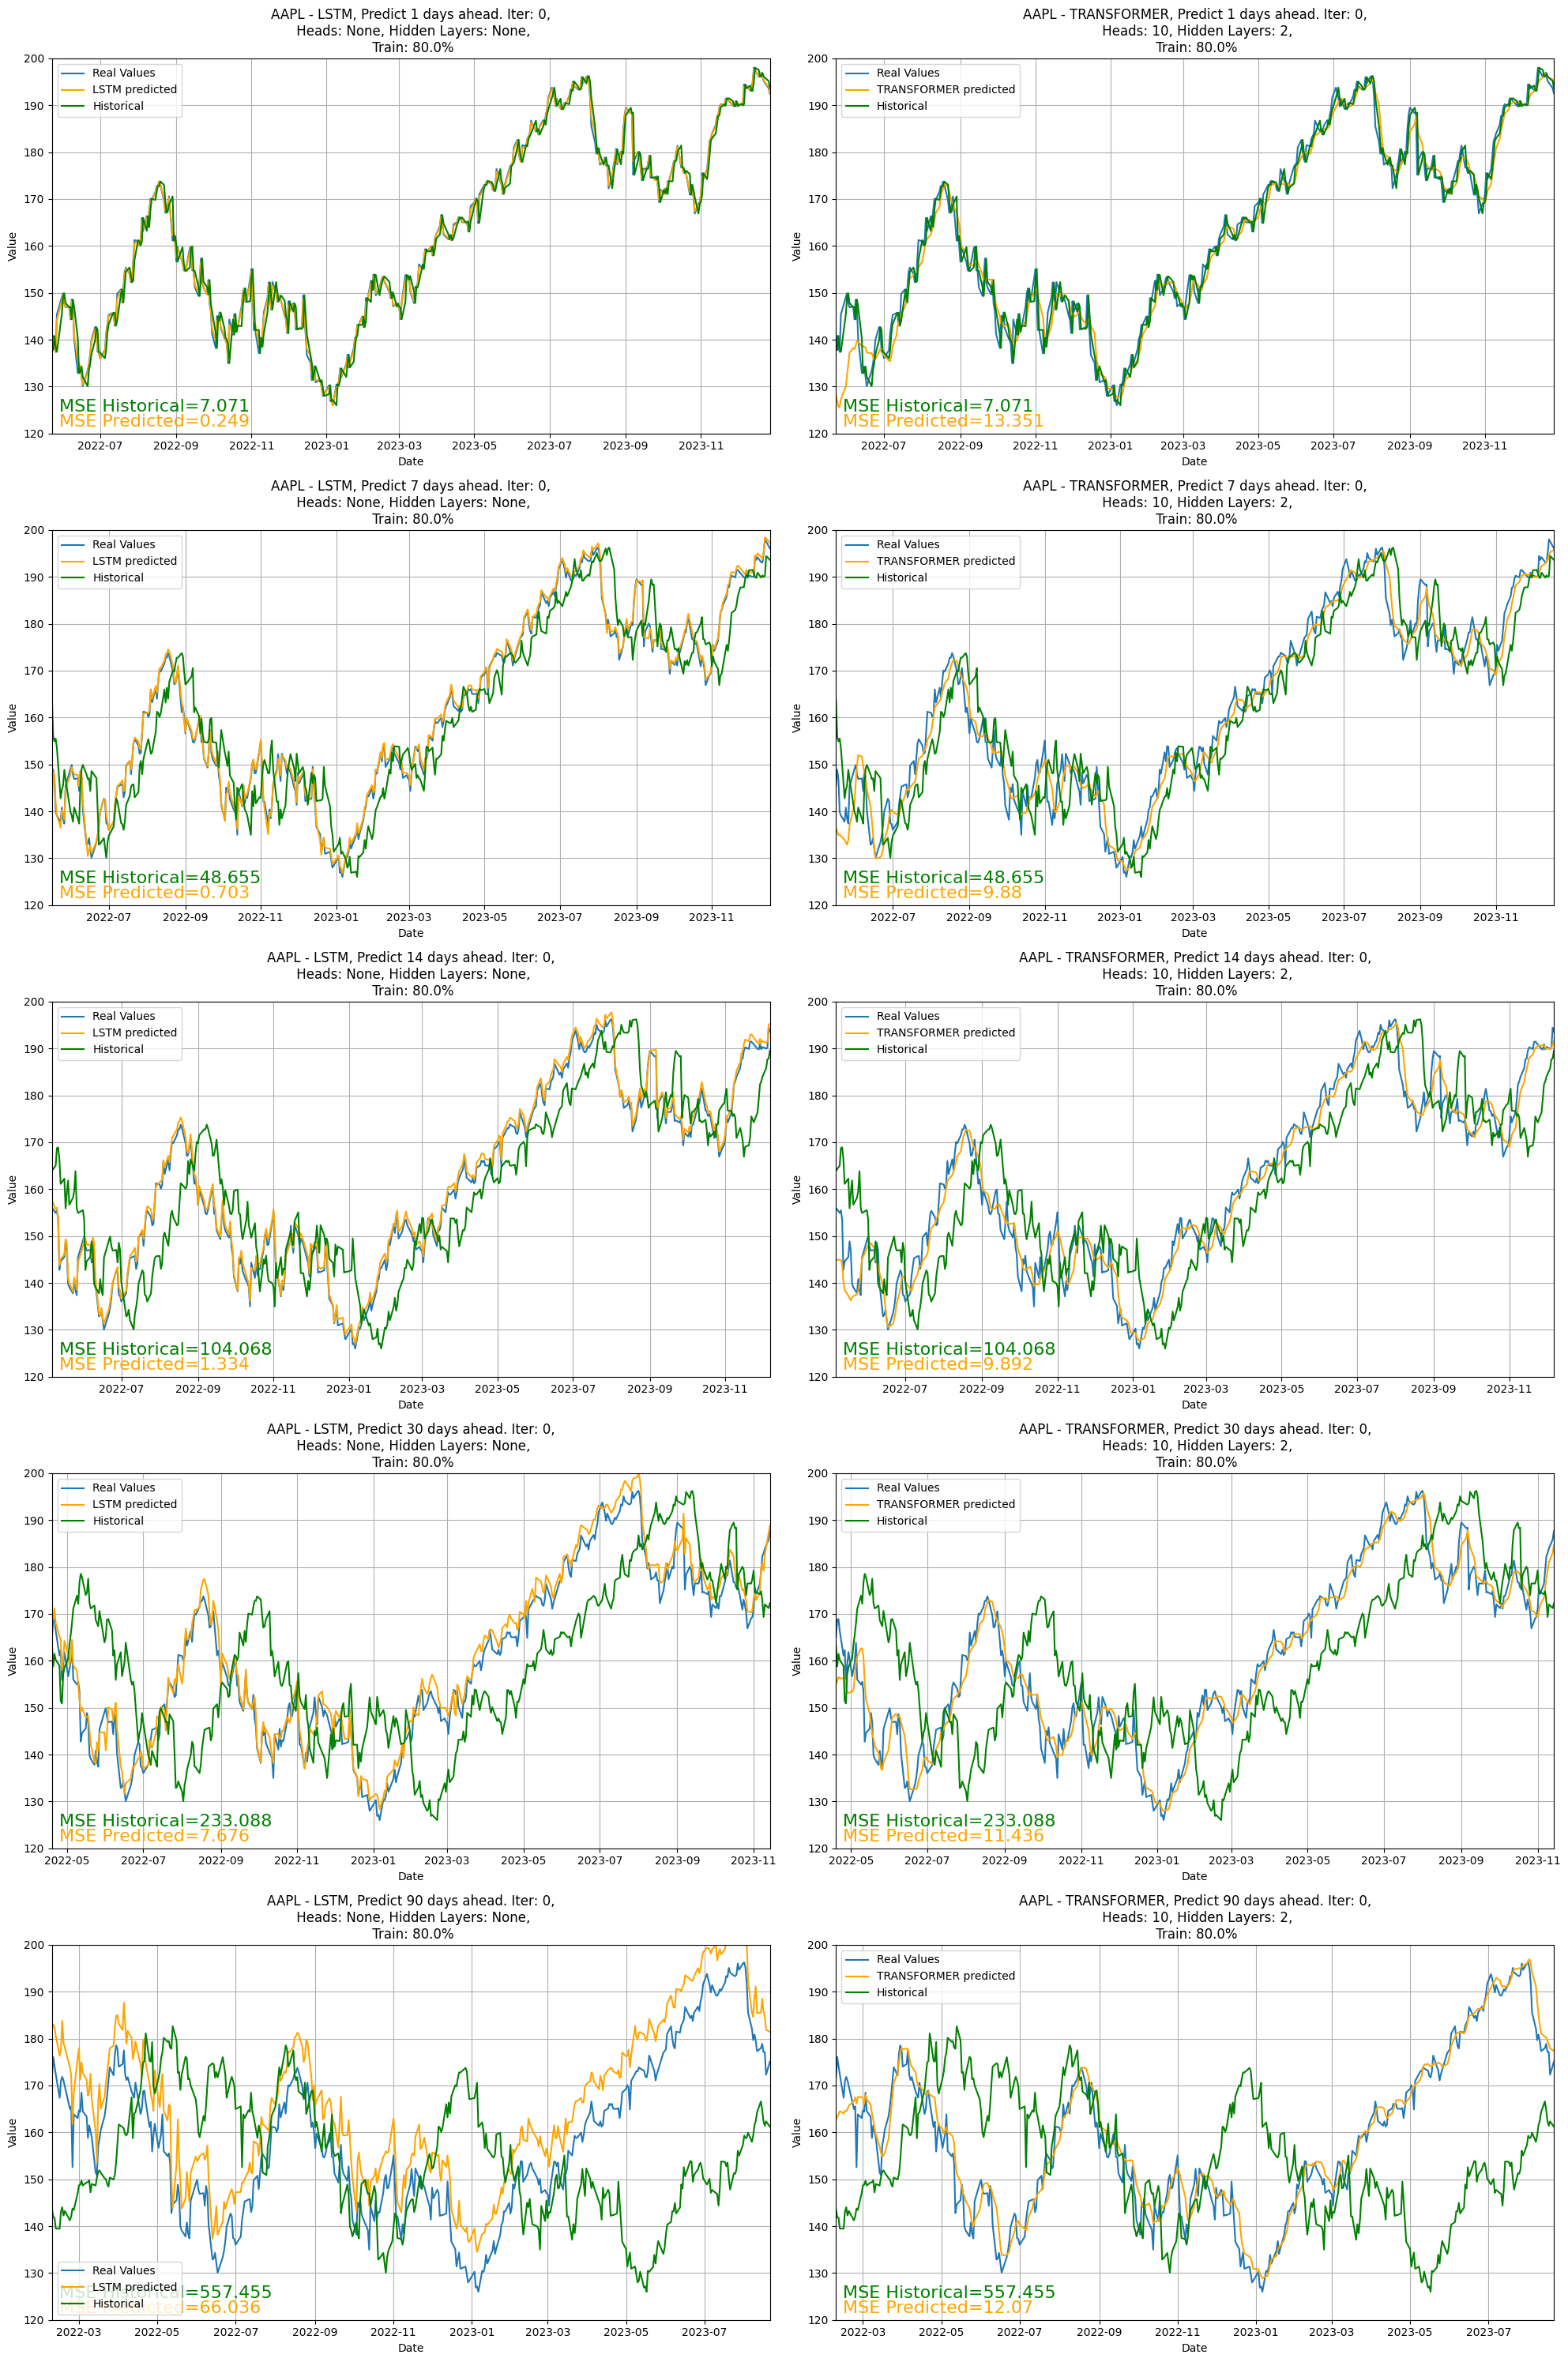

In [54]:

win_size = 5
stock = 'AAPL'
multi = False
num_iterations = 10
scen_name = 'scenario_1'
for tr_tst in list_tr_tst:
    processed_path = f"D:/Escritorio/TFG/Finance-AI/DataProcessed"

    all_res = load_output_preprocessed_data(processed_path, win_size, tr_tst, stock, multi)
    model_list = list(all_res.keys())

    model_results = all_res

    print(f'Plotting model with {tr_tst*100}% of training data.')
    for itr in range(1):
        plot_results_comparison(model_results, lahead, model_list, scen_name, stock, itr, tr_tst)


In [100]:
all_res['transformer']['tot_res']['OUT_MODEL'][1].keys()

Index(['MSEP', 'MSEY', 'Stock', 'DY', 'ALG', 'seed', 'epochs', 'nhn', 'win',
       'ndims', 'lossh', 'nit', 'model', 'ttrain', 'bsize', 'tr_tst',
       'transformer_parameters'],
      dtype='object')